### **GAN.ipynb Documentation**

This notebook provides a complete implementation of a Generative Adversarial Network (GAN) trained on the MNIST dataset. It includes all necessary steps from data loading to model evaluation.

**Deliverables Covered:**
1.  **Code for vanilla GAN**: `Generator` and `Discriminator` classes are implemented.
2.  **Loss Logging**: Generator & discriminator losses are logged per epoch.
3.  **Sample Generation**: Generated samples are saved every 5 epochs and at the end of training.
4.  **Loss Plots**: Loss curves are plotted after training.
5.  **IS and FID Scores**: Code is included to generate images and run the evaluation command.

#### **Cell 1: Imports**
Import all the necessary libraries for the project.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from torchvision.utils import save_image

#### **Cell 2: Device and Hyperparameters**
This cell sets up the device (GPU or CPU) and defines the key hyperparameters for the model and training process.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 100
image_size = 28 * 28
batch_size = 128
learning_rate = 0.0002
num_epochs = 50

#### **Cell 3: Data Loading and Preprocessing**
Here, we load the MNIST dataset. Images are converted to tensors and normalized to the range [-1, 1] to match the generator's output activation (`tanh`).

In [4]:
# Image processing and dataset loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.28MB/s]


#### **Cell 4: Discriminator Network**
The Discriminator is a standard feedforward neural network that classifies images as real or fake. It outputs a single probability value.

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

#### **Cell 5: Generator Network**
The Generator takes a random noise vector from the latent space and transforms it into a flattened image.

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, image_size),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

#### **Cell 6: Model Initialization, Loss, and Optimizers**
We initialize the models, move them to the configured device, and set up the Binary Cross-Entropy loss function and Adam optimizers.

In [7]:
# Initialize models
discriminator = Discriminator().to(device)
generator = Generator().to(device)

# Loss and optimizers
criterion = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)

#### **Cell 7: Training Loop with Logging**
This is the main training loop. It includes logic to:
1.  Calculate and store the average loss for both the generator and discriminator at the end of each epoch.
2.  Save a grid of generated image samples every 5 epochs to a directory named `gan_samples`.

In [8]:
# Lists to store loss history for plotting
d_losses = []
g_losses = []

# Create a directory to save samples
os.makedirs('gan_samples', exist_ok=True)

print("Starting Training...")
for epoch in range(num_epochs):
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    for i, (images, _) in enumerate(train_loader):
        # Prepare real and fake labels
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        # Reshape images for the linear layers
        images = images.reshape(-1, image_size).to(device)

        # --- Train Discriminator ---
        d_optimizer.zero_grad()

        # Loss on real images
        d_real_outputs = discriminator(images)
        d_loss_real = criterion(d_real_outputs, real_labels)

        # Loss on fake images
        z = torch.randn(images.size(0), latent_dim).to(device)
        fake_images = generator(z)
        d_fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(d_fake_outputs, fake_labels)

        # Total discriminator loss and backpropagation
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # --- Train Generator ---
        g_optimizer.zero_grad()
        # We need to run the fake images through the discriminator again
        g_outputs = discriminator(fake_images)
        g_loss = criterion(g_outputs, real_labels) # Generator wants discriminator to think these are real
        g_loss.backward()
        g_optimizer.step()

        # Accumulate losses for the epoch
        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()

    # --- End of Epoch Logging ---
    avg_d_loss = epoch_d_loss / len(train_loader)
    avg_g_loss = epoch_g_loss / len(train_loader)
    d_losses.append(avg_d_loss)
    g_losses.append(avg_g_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Discriminator Loss: {avg_d_loss:.4f}, Generator Loss: {avg_g_loss:.4f}')

    # Save generated samples every 5 epochs
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            z_sample = torch.randn(64, latent_dim).to(device)
            sample_images = generator(z_sample).view(-1, 1, 28, 28)
            save_image(sample_images, f'gan_samples/samples_epoch_{epoch+1}.png', normalize=True)

print("Training finished.")

# Save the trained generator model
torch.save(generator.state_dict(), 'generator_final.pth')

Starting Training...
Epoch [1/50], Discriminator Loss: 0.5946, Generator Loss: 3.5197
Epoch [2/50], Discriminator Loss: 0.4069, Generator Loss: 3.2554
Epoch [3/50], Discriminator Loss: 0.8323, Generator Loss: 2.9563
Epoch [4/50], Discriminator Loss: 0.8261, Generator Loss: 2.5212
Epoch [5/50], Discriminator Loss: 1.1529, Generator Loss: 2.2318
Epoch [6/50], Discriminator Loss: 0.8173, Generator Loss: 2.2952
Epoch [7/50], Discriminator Loss: 0.3026, Generator Loss: 2.8421
Epoch [8/50], Discriminator Loss: 0.3956, Generator Loss: 3.3894
Epoch [9/50], Discriminator Loss: 0.5876, Generator Loss: 3.6396
Epoch [10/50], Discriminator Loss: 0.6379, Generator Loss: 3.0582
Epoch [11/50], Discriminator Loss: 0.4583, Generator Loss: 2.9598
Epoch [12/50], Discriminator Loss: 0.4028, Generator Loss: 3.6699
Epoch [13/50], Discriminator Loss: 0.6691, Generator Loss: 3.7521
Epoch [14/50], Discriminator Loss: 0.5240, Generator Loss: 3.2709
Epoch [15/50], Discriminator Loss: 0.5638, Generator Loss: 3.180

#### **Deliverable 1: Final Trained Generator Samples**
This cell generates and saves the final batch of images from the fully trained generator.

Displaying final generated samples...


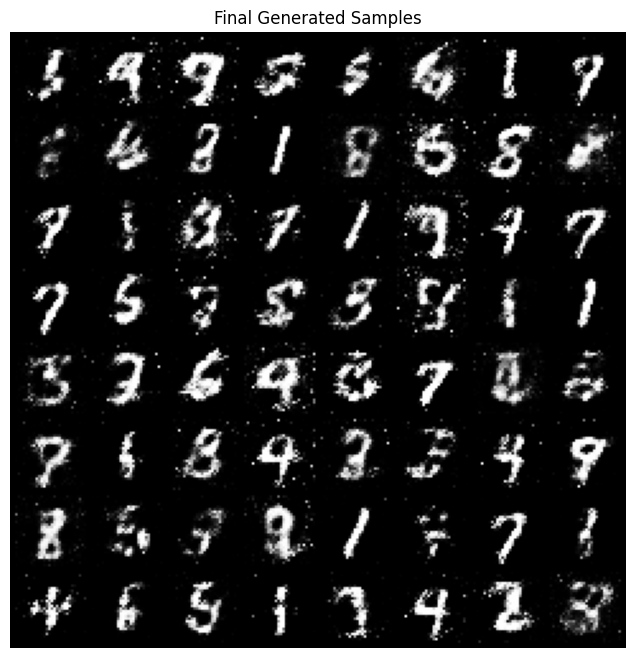

In [9]:
# Generate and save final samples
with torch.no_grad():
    z_final = torch.randn(64, latent_dim).to(device)
    final_images = generator(z_final).view(-1, 1, 28, 28)
    save_image(final_images, 'final_gan_samples.png', normalize=True)

    # Display the final grid
    print("Displaying final generated samples...")
    grid = torchvision.utils.make_grid(final_images, nrow=8, normalize=True)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.title('Final Generated Samples')
    plt.axis('off')
    plt.show()

#### **Deliverable 2: Loss Plots**
This cell plots the saved generator and discriminator losses to visualize their behavior over the training epochs.

Plotting loss curves...


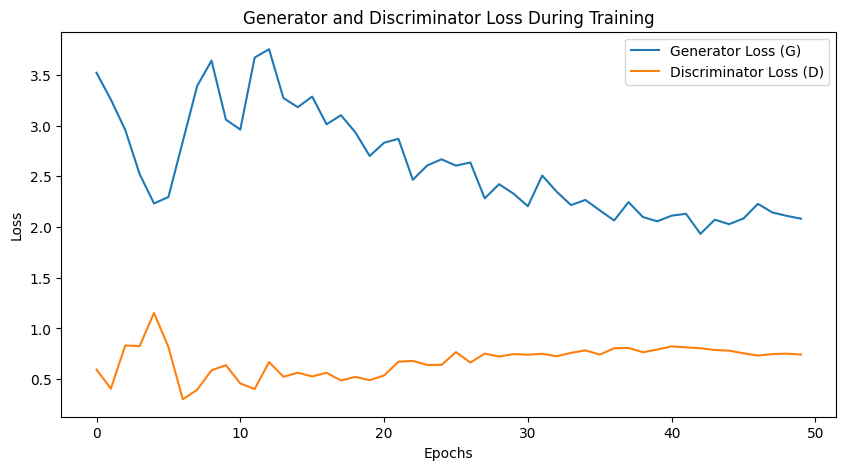

In [10]:
# Plot the loss curves
print("Plotting loss curves...")
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses, label="Generator Loss (G)")
plt.plot(d_losses, label="Discriminator Loss (D)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('loss_curves.png')
plt.show()

#### **Deliverable 3: IS and FID Scores**
To calculate the Inception Score (IS) and Fréchet Inception Distance (FID), we first need to generate a large number of samples. Then, we can use a library like `torch-fidelity` to compare them against the real dataset.

In [ ]:
# First, ensure the evaluation library is installed
!pip install torch-fidelity

In [12]:
import os

# --- Generate a large number of images for evaluation ---
eval_dir = 'eval_images'
os.makedirs(eval_dir, exist_ok=True)

num_eval_images = 10000 # Standard number for FID/IS
eval_batch_size = 100

print(f"Generating {num_eval_images} images for evaluation...")
generator.eval() # Set generator to evaluation mode
with torch.no_grad():
    for i in range(0, num_eval_images, eval_batch_size):
        z = torch.randn(eval_batch_size, latent_dim).to(device)
        generated_images = generator(z).view(-1, 1, 28, 28)

        for j in range(generated_images.size(0)):
            save_image(generated_images[j, :, :, :], os.path.join(eval_dir, f'img_{i+j}.png'), normalize=True)

print("Images generated successfully.")

Generating 10000 images for evaluation...
Images generated successfully.


#### **Final Step: Command for Metric Calculation**

**Important:** The following command should be run in your **terminal/shell** from the same directory as your notebook. It uses `torch-fidelity` to calculate the metrics. The `--input2 mnist-train` argument tells the library to automatically use the PyTorch MNIST training set as the real data for comparison.

You can also run it from a notebook cell by prefixing it with `!`, as shown below.

In [17]:
# --- Create a Directory of Real MNIST Images for Comparison ---
#
# The torch-fidelity library does not have a built-in keyword for the MNIST dataset.
# Therefore, we must manually save the real training images to a directory so we can
# provide a path to it for the --input2 argument.

real_images_dir = 'real_mnist_images'
os.makedirs(real_images_dir, exist_ok=True)

print(f"Saving real MNIST images to '{real_images_dir}'...")

# Create a dataloader without shuffling to save images in order
real_train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)

img_num = 0
for i, (images, _) in enumerate(real_train_loader):
    for j in range(images.size(0)):
        save_image(images[j, :, :, :], os.path.join(real_images_dir, f'real_img_{img_num}.png'), normalize=True)
        img_num += 1

print("Finished saving real images.")

Saving real MNIST images to 'real_mnist_images'...
Finished saving real images.


In [18]:
# --- Verification Step (Optional but Recommended) ---
# Let's first confirm that your images were generated correctly.
# This command lists the first 5 files in the directory.
print("Verifying that generated images exist...")
!ls -l /content/eval_images | head -n 5

# This command counts the total number of images to ensure generation is complete.
print("\nCounting total generated images...")
!ls /content/eval_images | wc -l
!ls /content/real_mnist_images | wc -l

print("Running final FID and IS calculation...")

!python -m torch_fidelity.fidelity --gpu 0 --fid --isc --input1 /content/eval_images --input2 /content/real_mnist_images
# !torch-fidelity --gpu 0 --fid --isc --input1 /content/eval_images --input2 mnist-train

Verifying that generated images exist...
total 40000
-rw-r--r-- 1 root root  626 Aug 11 17:16 img_0.png
-rw-r--r-- 1 root root  618 Aug 11 17:16 img_1000.png
-rw-r--r-- 1 root root  621 Aug 11 17:16 img_1001.png
-rw-r--r-- 1 root root  928 Aug 11 17:16 img_1002.png

Counting total generated images...
10000
60000
Running final FID and IS calculation...
Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']
Extracting features from input1
Looking for samples non-recursivelty in "/content/eval_images" with extensions png,jpg,jpeg
Found 10000 samples
/usr/local/lib/python3.11/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(